In [24]:
import pandas as pd
import numpy as np
from scipy.stats import poisson, norm
import matplotlib.pyplot as plt
from collections import Counter, defaultdict

## Question 1

In [3]:
files = {
    "E. coli (K12)": "ecoli.chrom.sizes",
    "Yeast (sacCer3)": "yeast.chrom.sizes",
    "Worm (ce10)": "ce10.chrom.sizes",
    "Fruit Fly (dm6)": "dm6.chrom.sizes",
    "Arabidopsis (TAIR10)": "TAIR10.chrom.sizes",
    "Tomato (SL v4.00)": "tomato.chrom.sizes",
    "Human (hg38)": "hg38.chrom.sizes",
    "Wheat (IWGSC)": "wheat.chrom.sizes"
}

In [4]:
results = []

for species, filename in files.items():
    df = pd.read_csv(filename, sep="\t", header=None, names=["chrom", "size"])
    
    total_size = df["size"].sum()
    n_chroms = len(df)
    largest_chrom = df.loc[df["size"].idxmax()]
    smallest_chrom = df.loc[df["size"].idxmin()]
    mean_size = total_size / n_chroms
    
    results.append({
        "Species": species,
        "Total Genome Size (bp)": total_size,
        "Num Chromosomes": n_chroms,
        "Largest Chromosome": f"{largest_chrom['chrom']} ({largest_chrom['size']})",
        "Smallest Chromosome": f"{smallest_chrom['chrom']} ({smallest_chrom['size']})",
        "Mean Chromosome Size (bp)": round(mean_size, 2)
    })

results_df = pd.DataFrame(results)

In [5]:
results_df

,Species,Total Genome Size (bp),Num Chromosomes,Largest Chromosome,Smallest Chromosome,Mean Chromosome Size (bp)
0,E. coli (K12),4639211,1,Ecoli (4639211),Ecoli (4639211),4.639211e+06
1,Yeast (sacCer3),12157105,17,chrIV (1531933),chrM (85779),7.151238e+05
2,Worm (ce10),100286070,7,chrV (20924149),chrM (13794),1.432658e+07
3,Fruit Fly (dm6),137547960,7,chr3R (32079331),chr4 (1348131),1.964971e+07
4,Arabidopsis (TAIR10),119146348,5,Chr1 (30427671),Chr4 (18585056),2.382927e+07
5,Tomato (SL v4.00),782520033,13,ch01 (90863682),ch00 (9643250),6.019385e+07
6,Human (hg38),3088269832,24,chr1 (248956422),chr21 (46709983),1.286779e+08
7,Wheat (IWGSC),14547261565,22,3B (830829764),6D (473592718),6.612392e+08


In [6]:
print(results_df.to_string(index=True))

                Species  Total Genome Size (bp)  Num Chromosomes Largest Chromosome Smallest Chromosome  Mean Chromosome Size (bp)
0         E. coli (K12)                 4639211                1    Ecoli (4639211)     Ecoli (4639211)               4.639211e+06
1       Yeast (sacCer3)                12157105               17    chrIV (1531933)        chrM (85779)               7.151238e+05
2           Worm (ce10)               100286070                7    chrV (20924149)        chrM (13794)               1.432658e+07
3       Fruit Fly (dm6)               137547960                7   chr3R (32079331)      chr4 (1348131)               1.964971e+07
4  Arabidopsis (TAIR10)               119146348                5    Chr1 (30427671)     Chr4 (18585056)               2.382927e+07
5     Tomato (SL v4.00)               782520033               13   ch01  (90863682)      ch00 (9643250)               6.019385e+07
6          Human (hg38)              3088269832               24   chr1 (248956422)

## Question 2

##### Question 2.1. How many 100bp reads are needed to sequence a 1Mbp genome to 3x coverage?

##### 2.1: Coverage (C) = N * L / G, here C=3, G=1000000bp , L=100bp. Therefore:

In [7]:
C=3
G=1000000
L=100
N=(C*G)/L

In [8]:
print(f"Number of reads (N) needed: {N}")

Number of reads (N) needed: 30000.0


##### Question 2.2

In [9]:
genomesize = 1_000_000
readlength = 100
coverage = 3

In [10]:
def calculate_number_of_reads(genomesize, readlength, coverage):
    return (coverage * genomesize) // readlength

In [11]:
def coverage_dist(genomesize, readlength, coverage, poisson_lambda, normal_mean, normal_std):
    num_reads = calculate_number_of_reads(genomesize, readlength, coverage)
    genome_coverage = np.zeros(genomesize, dtype=int)

    for _ in range(num_reads):
        startpos = np.random.randint(0, genomesize - readlength + 1)  # inclusive start
        genome_coverage[startpos:startpos + readlength] += 1
    
    maxcoverage = genome_coverage.max()
    histogram = np.zeros(maxcoverage + 1, dtype=int)

    for cov in genome_coverage:
        histogram[cov] += 1
    hist_freq = histogram / genomesize
    x_vals = np.arange(len(hist_freq))
    plt.bar(x_vals, hist_freq, width=1.0, alpha=0.6, label="Simulated coverage")
    plt.plot(x_vals, poisson.pmf(x_vals, mu=poisson_lambda), 'r-', lw=1, label="Poisson(λ=3)")
    x_cont = np.linspace(0, maxcoverage, 200)
    plt.plot(x_cont, norm.pdf(x_cont, loc=normal_mean, scale=normal_std), 'g--', lw=2, label="Normal(μ=3, σ≈1.73)")
    plt.xlabel("Coverage depth")
    plt.ylabel("Fraction of bases")
    plt.title("Simulated sequencing coverage (3×, 100 bp reads, 1 Mbp genome)")
    plt.legend()
    plt.show()

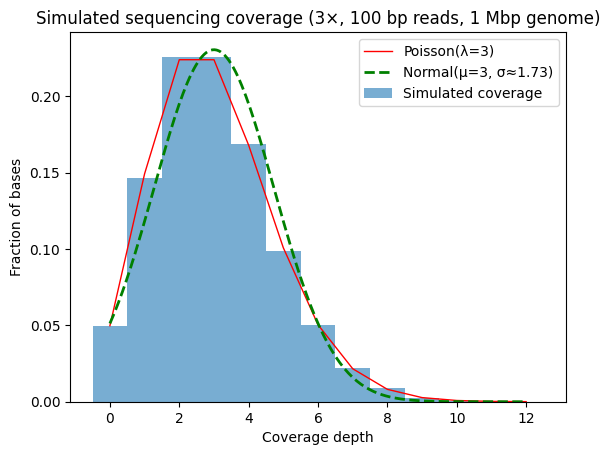

In [12]:
coverage_dist(genomesize=1_000_000, readlength=100, coverage=3, poisson_lambda=3, normal_mean=3, normal_std=1.73)

Question 2.3. Using the histogram from Q2.2, how much of the genome has not been sequenced (has 0x coverage)? How well does this match Poisson expectations? How well does the normal distribution fit the data?

Answer: 5% of the genome has not been sequenced. 

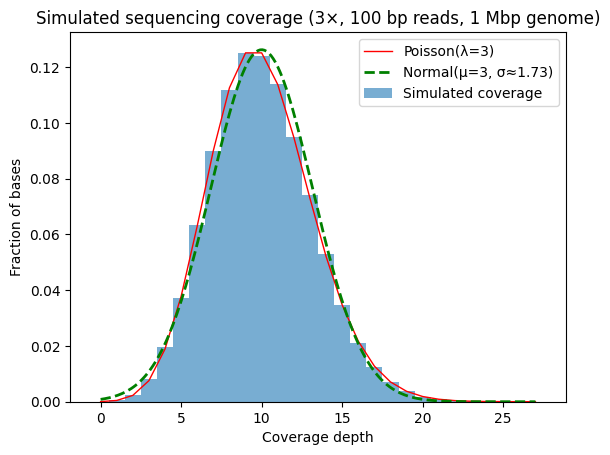

In [13]:
coverage_dist(genomesize=1_000_000, readlength=100, coverage=10, poisson_lambda=10, normal_mean=10, normal_std=3.16)

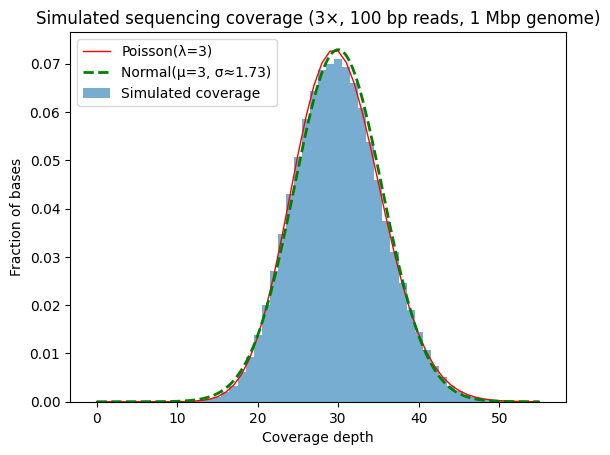

In [14]:
coverage_dist(genomesize=1_000_000, readlength=100, coverage=30, poisson_lambda=30, normal_mean=30, normal_std=5.47)

#### Question 3

In [22]:
from collections import Counter

def read_genome(file_path):
    with open(file_path, 'r') as f:
        genome = ""
        for line in f:
            if line.startswith(">"):
                continue  # Skip header lines
            genome += line.strip().upper()  # Convert to uppercase and strip whitespace
        return genome

# Read the genome sequence
genome_string = read_genome("chr22.fa")

# Replace invalid bases with 'N'
genome_string = ''.join([base if base in 'ACGT' else 'N' for base in genome_string])

# Count the occurrences of A, C, G, T, N
base_counts = Counter(genome_string)

# Output the counts
print("Base counts:")
for base in ['A', 'C', 'G', 'T', 'N']:
    print(f"{base}: {base_counts.get(base, 0)}")


Base counts:
A: 10382214
C: 9160652
G: 9246186
T: 10370725
N: 11658691


Frequency Spectrum (1–20):
1	29427206
2	989881
3	264956
4	123283
5	57183
6	32997
7	23784
8	17021
9	13268
10	10842
11	9082
12	7525
13	6495
14	5728
15	4828
16	4392
17	3980
18	3463
19	3094
20	2805


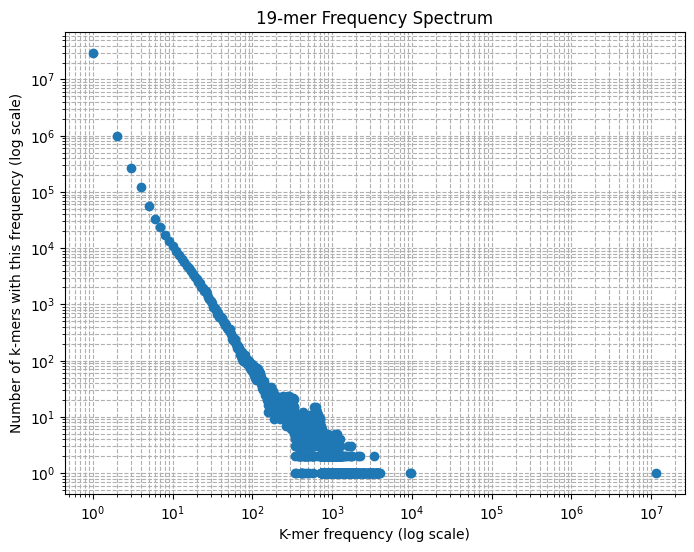


Percentages:
Unique kmers: 57.91%
Repetitive kmers (>1 occurrence): 42.09%
Kmers occurring >1000 times: 24.44%


In [ ]:
genome_length = len(genome_string)
k=19

kmer_counts = defaultdict(int)
for i in range(genome_length - k + 1):
    kmer = genome_string[i:i+k]
    kmer_counts[kmer] += 1

freq_tally = Counter(kmer_counts.values())
max_freq = max(freq_tally.keys())

print("Frequency Spectrum (1–20):")
for i in range(1, 21):
    print(f"{i}\t{freq_tally.get(i, 0)}")

x = sorted(freq_tally.keys())
y = [freq_tally[f] for f in x]

plt.figure(figsize=(8,6))
plt.loglog(x, y, marker='o', linestyle='none')
plt.xlabel("K-mer frequency (log scale)")
plt.ylabel("Number of k-mers with this frequency (log scale)")
plt.title(f"{k}-mer Frequency Spectrum")
plt.grid(True, which="both", ls="--")
plt.show()

total_kmers = genome_length - k + 1
unique_kmers_count = freq_tally.get(1, 0)

repetitive_kmers_count = total_kmers - unique_kmers_count

highly_repetitive_count = sum(freq * count for freq, count in freq_tally.items() if freq > 1000)

unique_pct = (unique_kmers_count / total_kmers) * 100
repetitive_pct = (repetitive_kmers_count / total_kmers) * 100
highly_repetitive_pct = (highly_repetitive_count / total_kmers) * 100

print("\nPercentages:")
print(f"Unique kmers: {unique_pct:.2f}%")
print(f"Repetitive kmers (>1 occurrence): {repetitive_pct:.2f}%")
print(f"Kmers occurring >1000 times: {highly_repetitive_pct:.2f}%")